In [1]:
from openseespy import opensees as ops
from display import display_structure
from structural.structure import TenBarsPlanarTruss
from structural.analysis import LinearAnalysis
t = TenBarsPlanarTruss()
l = LinearAnalysis()

In [2]:
param = {"length": 2, "height": 2,

         "A_0": 1e-3, "A_1": 1e-3, "A_2": 1e-3, "A_3": 1e-3, "A_4": 1e-3, "A_5": 1e-3, "A_6": 1e-3, "A_7": 1e-3,
         "A_8": 1e-3, "A_9": 1e-3,

         "E_0": 70e9, "E_1": 70e9, "E_2": 70e9, "E_3": 70e9, "E_4": 70e9, "E_5": 70e9, "E_6": 70e9, "E_7": 70e9,
         "E_8": 70e9, "E_9": 70e9,

         "P_x_0": 0., "P_y_0": 0., "P_x_1": 0., "P_y_1": 0., "P_x_2": 0., "P_y_2": 0., "P_x_3": 0., "P_y_3": 0.,
         "P_x_4": 0., "P_y_4": 100.e3, "P_x_5": 0., "P_y_5": 100.e3, }

t.generate_model(param)
l.run_analysis()

In [3]:
ops.nodeDOFs(2)

[2, 3]

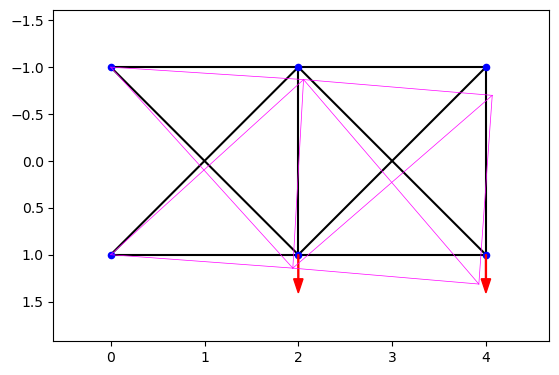

In [4]:
display_structure(def_scale=10)

In [1]:
from typing import Dict, Callable, Any

from dataset2 import AbstractGenerator
from structural.analysis import AbstractAnalysis
from structural.structure.abstract_structure import AbstractStructure
import numpy as np


class G(AbstractGenerator):

    @property
    def default_config(self) -> Dict[str, Dict[str, str | int | float]]:
        return {

                'u': {'distribution': 'constant', 'value': 0, }, 'v': {'distribution': 'constant', 'value': 1, },
                'x': {'distribution': 'constant', 'value': 2, }, 'y': {'distribution': 'constant', 'value': 3, },
                'z': {'distribution': 'constant', 'value': 4, }, }

    @property
    def structure(self) -> AbstractStructure:
        pass

    @property
    def analysis(self) -> AbstractAnalysis:
        pass

    def construct_result(self, params: Dict[str, float | int]) -> Dict[str, float]:
        pass


g = G(
        {'n_sample': 3, 'parameters': {'test': {'distribution': 'normal', 'mean': 5, 'std': 8, },
                                       'x': {'distribution': 'constant', 'value': -2, }, 'y': {"shared_with": 'test'},
                                       'z': {"shared_with": 'test'}, }}
        )
for _ in g.__iter__():
    pass

{'u': {'distribution': 'constant', 'value': 0}, 'v': {'distribution': 'constant', 'value': 1}, 'x': {'distribution': 'constant', 'value': 2}, 'y': {'distribution': 'constant', 'value': 3}, 'z': {'distribution': 'constant', 'value': 4}}
{'test': {'distribution': 'normal', 'mean': 5, 'std': 8}, 'x': {'distribution': 'constant', 'value': -2}, 'y': {'shared_with': 'test'}, 'z': {'shared_with': 'test'}}
{'u': {'distribution': 'constant', 'value': 0}, 'v': {'distribution': 'constant', 'value': 1}, 'x': {'distribution': 'constant', 'value': -2}, 'y': {'shared_with': 'test'}, 'z': {'shared_with': 'test'}, 'test': {'distribution': 'normal', 'mean': 5, 'std': 8}}
{'u': <function AbstractGenerator.get_distribution.<locals>.<lambda> at 0x000001F96F9F5300>, 'v': <function AbstractGenerator.get_distribution.<locals>.<lambda> at 0x000001F96F9F53A0>, 'x': <function AbstractGenerator.get_distribution.<locals>.<lambda> at 0x000001F96F9F5440>, 'test': <function AbstractGenerator.get_distribution.<locals>

In [107]:
import openseespy.opensees as ops
import numpy as np
from dataset.generation.generator import StructuralDatasetGenerator

In [110]:
def loads():
    n_dof = 2
    n_nodes = 5

    q = np.zeros(n_dof*n_nodes)
    idx_nodes = ops.getNodeLoadTags()
    load_data = ops.getNodeLoadData()

    for i, idx in enumerate(idx_nodes):
        # Map the index based on the number of degrees of freedom
        i *= n_dof
        idx *= n_dof

        # Update the data
        q[idx:idx + n_dof] = load_data[i:i + n_dof]

    return q

In [111]:
loads()

array([         0.,          0.,          0.,          0.,          0.,          0.,   -3.00e+04,          0.,          0.,    5.00e+04])

In [94]:
ops.getNodeLoadData()

[-30000.0, 0.0, 0.0, 50000.0]

In [99]:
ops.getNodeLoadTags()

[3, 4]

In [86]:
ops.basicForce(0)

[24999.999999999996]

In [79]:
ops.wipe()

# set modelbuilder
ops.model('basic', '-ndm', 2, '-ndf', 2)

ops.node(0, 0., 0.)
ops.node(1, 0., 2.)
ops.node(2, 2., 0.)
ops.node(3, 2., 2.)
ops.node(4, 4., 0.)

ops.fix(0, 1, 1)
ops.fix(1, 1, 1)
ops.fix(4, 1, 0)

ops.uniaxialMaterial("Elastic", 1, 150.0e6)

ops.element("Truss", 0, 0, 2, 1.0, 1)
ops.element("Truss", 1, 2, 4, 1.0, 1)
ops.element("Truss", 2, 1, 3, 1.0, 1)
ops.element("Truss", 3, 2, 3, 1.0, 1)
ops.element("Truss", 4, 1, 2, 1.0, 1)
ops.element("Truss", 5, 3, 4, 1.0, 1)

# create TimeSeries
ops.timeSeries("Linear", 1)

# create a plain load pattern
ops.pattern("Plain", 1, 1)

ops.load(3, -30.0e3, 0.0)
ops.load(4, 0.0, 50.0e3)

# create SOE
ops.system("BandSPD")

# create DOF number
ops.numberer("RCM")

# create constraint handler
ops.constraints("Plain")

# create integrator
ops.integrator("LoadControl", 1.0)

# create algorithm
ops.algorithm("Linear")

# create analysis object
ops.analysis("Static")

# perform the analysis
ops.analyze(1)

0

In [80]:
ops.nodeCoord(0)

[0.0, 0.0]

In [81]:
ops.eleNodes(0)

[0, 2]

In [82]:
def _get_r(a):
    '''Compute member rotation matrix'''
    c = np.cos(a)
    s = np.sin(a)
    return np.array(
            [[c, s, 0, 0], [-s, c, 0, 0], [0, 0, c, s], [0, 0, -s, c]]
            )


def _get_k_loc(idx):
    '''Compute the local element matrix'''
    return ops.basicStiffness(idx)*np.array(
            [[1, 0, -1, 0], [0, 0, 0, 0], [-1, 0, 1, 0], [0, 0, 0, 0]]
            )


def _get_k_global(k_loc, angle):
    '''Compute the global element matrix'''
    r = _get_r(angle)
    return r.T@k_loc@r

In [83]:
def get_K(ndof=2):
    '''Compute the global structural matrix'''
    # Parameters
    nodes = np.array([ops.nodeCoord(i) for i in ops.getNodeTags()], dtype=int)
    elems = np.array([ops.eleNodes(i) for i in ops.getEleTags()])

    elems_vec = np.array([nodes[e] - nodes[s] for s, e in elems])
    elems_angle = np.array([np.arctan2(*v[::-1]) - np.arctan2(0, 1) for v in elems_vec])

    # Stiffness matrix
    K = np.zeros((ndof*len(ops.getNodeTags()), ndof*len(ops.getNodeTags())))
    for idx in range(len(elems)):
        # Get element stiffness matrix
        s_i, e_i = elems[idx]*ndof
        angle = elems_angle[idx]

        k_loc = _get_k_loc(idx)
        k_glob = _get_k_global(k_loc, angle)

        # Assemble global stiffness matrix
        K[s_i: s_i + ndof, s_i: s_i + ndof] += k_glob[0:2, 0:2]
        K[e_i: e_i + ndof, e_i: e_i + ndof] += k_glob[2:4, 2:4]
        K[s_i: s_i + ndof, e_i: e_i + ndof] += k_glob[0:2, 2:4]
        K[e_i: e_i + ndof, s_i: s_i + ndof] += k_glob[2:4, 0:2]

    # Boundary condition
    for idx in range(len(nodes)):
        for i in ops.getFixedDOFs(idx):
            dof = ndof*idx + i - 1  # OSP indices starts at 1

            K[dof, :] = 0.
            K[:, dof] = 0.
            K[dof, dof] = 1.

    return K

In [84]:
k = get_K()
u = np.reshape([u for i in range(5) for u in ops.nodeDisp(i)], (10, 1))

In [85]:
1000*u

array([[         0.],
       [         0.],
       [         0.],
       [         0.],
       [   3.33e-01],
       [   2.22e+00],
       [  -1.07e+00],
       [   2.89e+00],
       [         0.],
       [   5.84e+00]])

In [71]:
np.round(k@u)

array([[         0.],
       [         0.],
       [         0.],
       [         0.],
       [         0.],
       [         0.],
       [  -3.00e+04],
       [         0.],
       [         0.],
       [   5.00e+04]])

In [68]:
print(get_K()/75e6)

[[        ~0.          0.          0.          0.          0.          0.          0.          0.          0.          0.]
 [         0.         ~0.          0.          0.          0.          0.          0.          0.          0.          0.]
 [         0.          0.         ~0.          0.          0.          0.          0.          0.          0.          0.]
 [         0.          0.          0.         ~0.          0.          0.          0.          0.          0.          0.]
 [         0.          0.          0.          0.    2.35e+00   -3.54e-01         ~0.         ~0.          0.          0.]
 [         0.          0.          0.          0.   -3.54e-01    1.35e+00         ~0.   -1.00e+00          0.          0.]
 [         0.          0.          0.          0.         ~0.         ~0.    1.35e+00   -3.54e-01          0.    3.54e-01]
 [         0.          0.          0.          0.         ~0.   -1.00e+00   -3.54e-01    1.35e+00          0.   -3.54e-01]
 [         0.   

In [34]:
for i in range(5):
    print(ops.nodeDisp(i))

[0.0, 0.0]
[0.0, 0.0]
[-0.00033333333333333327, 0.00221895141649746]
[0.00026666666666666625, 0.0028856180831641266]
[0.0, 0.00503790283299492]
